In [4]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
palette_name = "rocket"

# Results overview

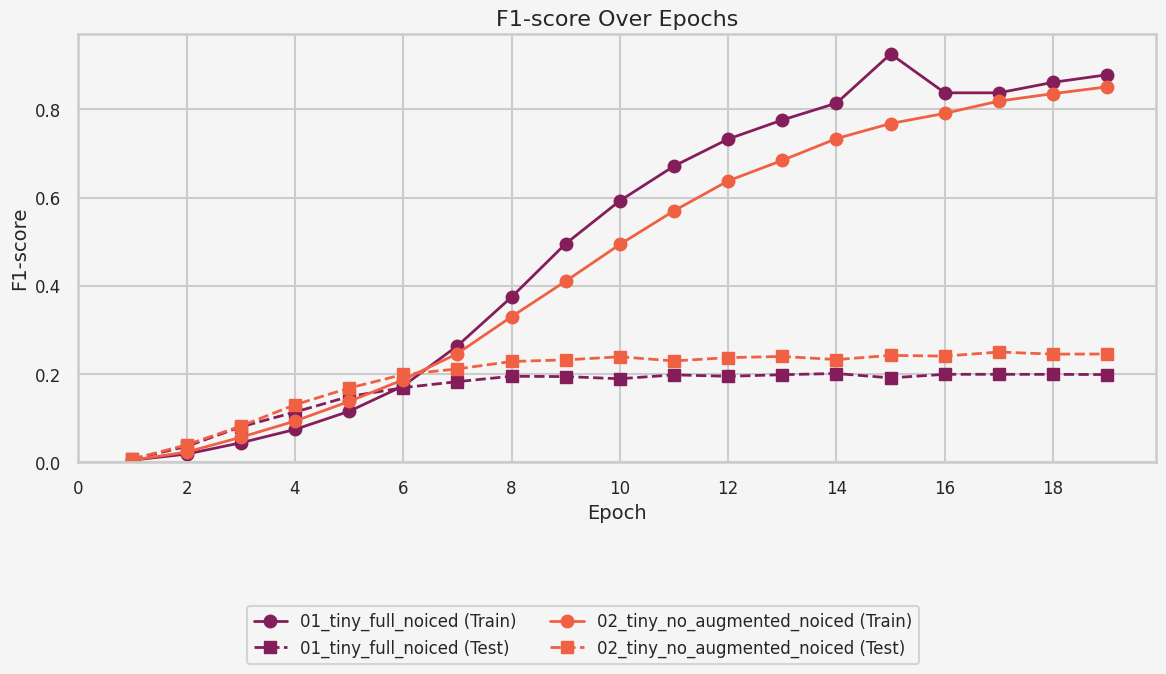

In [6]:


sns.set_theme(style="whitegrid", context="talk", palette="rocket")
plt.style.use('reports.mplstyle')

folder_path = "./bird_whisperer/experiments/results"
metrics = ["f1-score"]
results = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as f:
            data = json.load(f)
        
        model_name = os.path.splitext(filename)[0]
        results[model_name] = {"train": {}, "test": {}}
        
        train_data = data.get("train_metrics", [])
        test_data = data.get("test_metrics", [])
        
        for m in metrics:
            results[model_name]["train"][m] = [epoch_data[m] for epoch_data in train_data if m in epoch_data]
            results[model_name]["test"][m] = [epoch_data[m] for epoch_data in test_data if m in epoch_data]

model_names = list(results.keys())

min_train_length = min(len(results[mn]["train"][metrics[0]]) for mn in model_names)
min_test_length = min(len(results[mn]["test"][metrics[0]]) for mn in model_names)
num_epochs = min(min_train_length, min_test_length)
epochs = range(1, num_epochs + 1)

fig, ax = plt.subplots(nrows=1, ncols=len(metrics), figsize=(12, 6))
if len(metrics) == 1:
    axes = [ax]
else:
    axes = ax

color_palette = sns.color_palette(palette_name, n_colors=len(model_names))

for i, m in enumerate(metrics):
    current_ax = axes[i]

    for idx, model_name in enumerate(model_names):
        train_values = results[model_name]["train"][m][:num_epochs]
        test_values = results[model_name]["test"][m][:num_epochs]
        
        color = color_palette[idx]

        current_ax.plot(
            epochs, train_values, 
            label=f"{model_name} (Train)", 
            marker='o', 
            linestyle='-', 
            linewidth=2,
            color=color
        )
        
        current_ax.plot(
            epochs, test_values, 
            label=f"{model_name} (Test)", 
            marker='s', 
            linestyle='--', 
            linewidth=2,
            color=color
        )
    
    current_ax.set_title(f"{m.capitalize()} Over Epochs")
    current_ax.set_xlabel("Epoch")
    current_ax.set_ylabel(m.capitalize())
    current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    current_ax.set_ylim(bottom=0)
    current_ax.set_xlim(left=0)

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.subplots_adjust(bottom=0.2) 
plt.show()



# Data Splitting

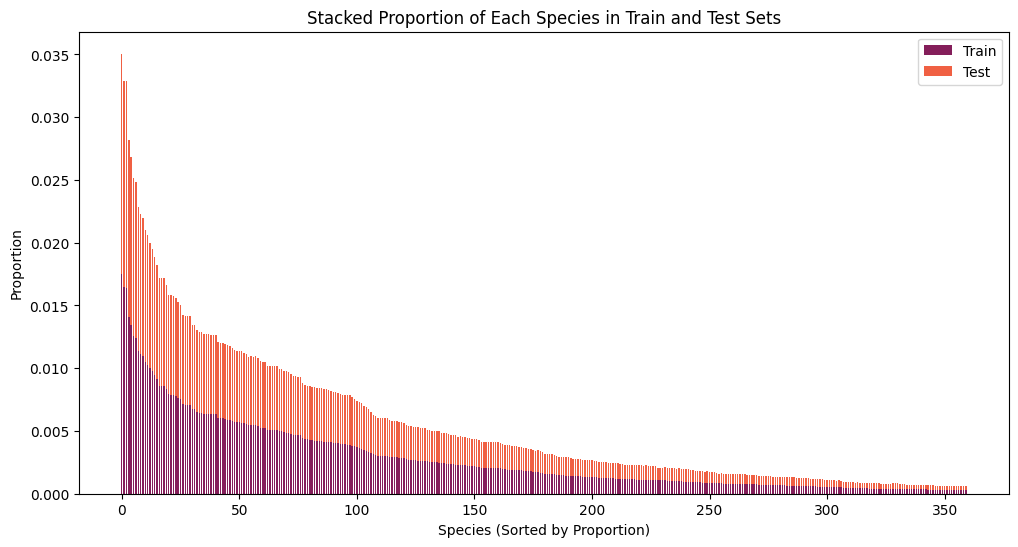

In [8]:
plt.rcdefaults()
sns.reset_orig()

file_location = "../data/cleaned/cleaned_data.parquet"
df = pd.read_parquet(file_location)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['en'], random_state=42)

train_props = train_df['en'].value_counts(normalize=True).sort_index()

test_props = test_df['en'].value_counts(normalize=True).sort_index()

distribution_df = pd.DataFrame({
    'Train': train_props,
    'Test': test_props
}).fillna(0)  

distribution_df = distribution_df.sort_values(by='Train', ascending=False)
color_palette = sns.color_palette(palette_name, 2)
species_indices = np.arange(len(distribution_df)) 
plt.figure(figsize=(12, 6))

plt.bar(species_indices, distribution_df['Train'], width=0.6, label='Train', color=color_palette[0])
plt.bar(species_indices, distribution_df['Test'], width=0.6, label='Test', bottom=distribution_df['Train'] , color=color_palette[1])

plt.xlabel('Species (Sorted by Proportion)')
plt.ylabel('Proportion')
plt.title('Stacked Proportion of Each Species in Train and Test Sets')
plt.legend()

plt.show()